# PyTorch CNN Model

## 0. Importing PyTorch Modules and setting up device

In [1]:
!pip install torchinfo

In [5]:
import torch
import torchvision
import helper_funcs as hlp
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.__version__, device


('2.3.0+cu121', 'cuda')

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Load Dataset

In [27]:
# Determine Image Size
IMAGE_X = 64
IMAGE_Y = 64
IMAGE_SIZE = (IMAGE_X, IMAGE_Y)

# Set Train and Test Directories
root_dir  = 'drive/MyDrive/PyTorch/dataset_egp'
train_dir = root_dir + "/train"
test_dir  = root_dir + '/test'


# Define Image Transformer
simple_transform = transforms.Compose([transforms.Resize(size=IMAGE_SIZE), transforms.ToTensor()])

# Get Train and Test data
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)
class_names = train_data_simple.classes

train_data_simple, test_data_simple,class_names

(Dataset ImageFolder
     Number of datapoints: 2560
     Root location: drive/MyDrive/PyTorch/dataset_egp/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 600
     Root location: drive/MyDrive/PyTorch/dataset_egp/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 ['egp_10',
  'egp_100',
  'egp_10_new',
  'egp_20',
  'egp_200',
  'egp_20_new',
  'egp_5',
  'egp_50'])

## 2. Visualize Data

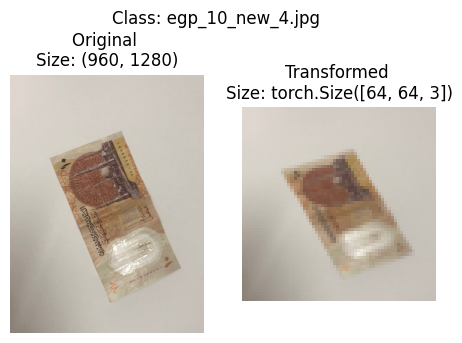

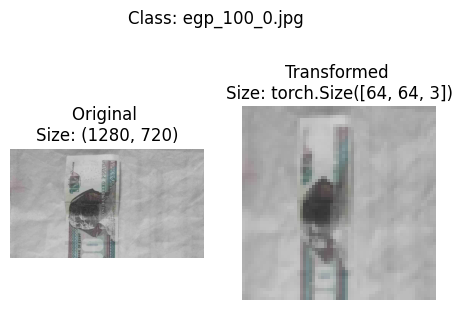

In [28]:
# Plot Images after transforming
hlp.plot_transformed_images(image_paths=root_dir, transform=simple_transform, n=2)

## 3. Group Data to batches

In [29]:
# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = 2

# Create DataLoader
train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7abeac0b14e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7abeacc72bc0>)

## 4. Design Model

In [39]:
IN_CHANNELS     = 3   # Color Channels
HIDDEN_UNITS    = 10
OUTPUT_SHAPE = len(train_data_simple.classes)
SIMPLE_MODEL_PATH = 'simple_model.pth'


simple_model = nn.Sequential(
    nn.Conv2d(in_channels=IN_CHANNELS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1,  padding=0),
    nn.BatchNorm2d(HIDDEN_UNITS),
    nn.ReLU(),
    nn.Conv2d(in_channels=HIDDEN_UNITS, out_channels=HIDDEN_UNITS, kernel_size=3, stride=1, padding=0),
    nn.BatchNorm2d(HIDDEN_UNITS),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=0),
    nn.BatchNorm2d(HIDDEN_UNITS),
    nn.ReLU(),
    nn.Conv2d(HIDDEN_UNITS, HIDDEN_UNITS, kernel_size=3, padding=0),
    nn.BatchNorm2d(HIDDEN_UNITS),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(in_features=HIDDEN_UNITS*13*13, out_features=OUTPUT_SHAPE)
).to(device)

try:
    simple_model.load_state_dict(torch.load(f=SIMPLE_MODEL_PATH))
except FileNotFoundError:
    pass

simple_model

Sequential(
  (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (8): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (11): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Dropout(p=0.5, inplace=False)
  (16): Linear(in_features=1690, out_features=8, bias=True)
)

In [40]:
# Verify Model using torchinfo.summary
summary(simple_model, input_size=[1, 3, IMAGE_X, IMAGE_Y])

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 8]                    --
├─Conv2d: 1-1                            [1, 10, 62, 62]           280
├─BatchNorm2d: 1-2                       [1, 10, 62, 62]           20
├─ReLU: 1-3                              [1, 10, 62, 62]           --
├─Conv2d: 1-4                            [1, 10, 60, 60]           910
├─BatchNorm2d: 1-5                       [1, 10, 60, 60]           20
├─ReLU: 1-6                              [1, 10, 60, 60]           --
├─MaxPool2d: 1-7                         [1, 10, 30, 30]           --
├─Conv2d: 1-8                            [1, 10, 28, 28]           910
├─BatchNorm2d: 1-9                       [1, 10, 28, 28]           20
├─ReLU: 1-10                             [1, 10, 28, 28]           --
├─Conv2d: 1-11                           [1, 10, 26, 26]           910
├─BatchNorm2d: 1-12                      [1, 10, 26, 26]           20
├─ReLU: 1-1

## 5. Train Model

In [41]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn_simple   = nn.CrossEntropyLoss()
optimizer_simple = torch.optim.Adam(params=simple_model.parameters(), lr=0.001)

simple_model_results = hlp.train_model(model=simple_model, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple,
                                       optimizer=optimizer_simple, loss_fn=loss_fn_simple, epochs=NUM_EPOCHS, device=device)

# Save Model
torch.save(obj=simple_model.state_dict(),f=SIMPLE_MODEL_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3547 | train_acc: 0.1336 | test_loss: 2.0902 | test_acc: 0.1234
Epoch: 2 | train_loss: 2.0910 | train_acc: 0.1172 | test_loss: 2.0833 | test_acc: 0.1365
Epoch: 3 | train_loss: 2.0889 | train_acc: 0.1187 | test_loss: 2.0836 | test_acc: 0.1234


KeyboardInterrupt: 

## 6. Evaluate Model

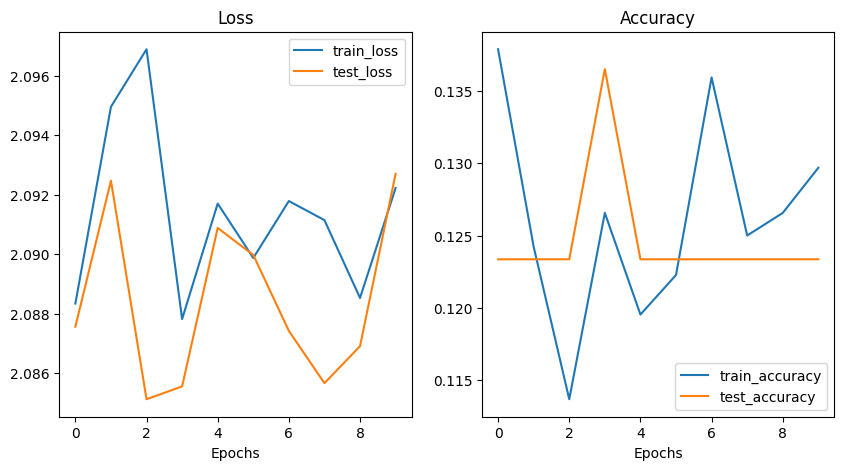

In [35]:
hlp.plot_loss_curves(simple_model_results)

## 7. Predict using custom data

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_5_3.jpg


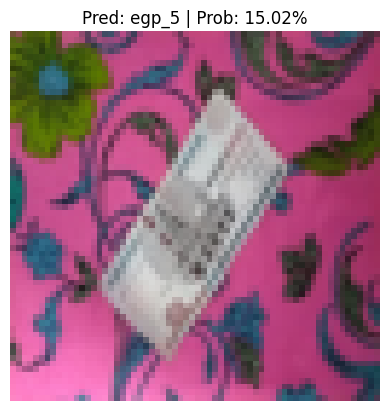

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_50_3.jpg


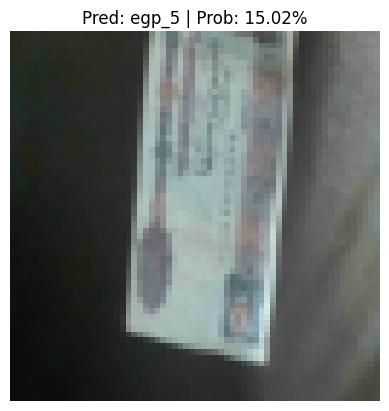

In [36]:
test_dir = root_dir + '/validate'

custom_image_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE),])

hlp.pred_and_plot_images(model=simple_model, image_dir=test_dir, class_names=class_names,
                         transform=custom_image_transform, device=device,num_images=2)

## 8. Trying a pretrained model

In [18]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()

# Turn images into DataLoaders
train_dataloader = DataLoader(train_data_simple, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True )

test_dataloader  = DataLoader(test_data_simple , batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

auto_transforms, train_dataloader, test_dataloader

(ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ),
 <torch.utils.data.dataloader.DataLoader at 0x7abed3c45de0>)

In [19]:
TRAINED_MODEL_PATH = 'trained_model.pth'

trained_model = torchvision.models.efficientnet_b0(weights=weights).to(device)

for param in trained_model.features.parameters():
  param.requires_grad = False

trained_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names))
    ).to(device)

try:
    trained_model.load_state_dict(torch.load(f=TRAINED_MODEL_PATH))
except :
    pass

trained_model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [20]:
summary(model=trained_model,input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 8]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [21]:
# Number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=trained_model.parameters(), lr=0.001)

trained_model_results = hlp.train_model(model=trained_model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
                                       optimizer=optimizer, loss_fn=loss_fn, epochs=NUM_EPOCHS, device=device)

# Save Model
torch.save(obj=simple_model.state_dict(),f=TRAINED_MODEL_PATH)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5408 | train_acc: 0.5563 | test_loss: 1.0588 | test_acc: 0.8114
Epoch: 2 | train_loss: 0.9489 | train_acc: 0.8008 | test_loss: 0.7466 | test_acc: 0.8651
Epoch: 3 | train_loss: 0.7228 | train_acc: 0.8410 | test_loss: 0.5890 | test_acc: 0.8849
Epoch: 4 | train_loss: 0.5964 | train_acc: 0.8637 | test_loss: 0.5054 | test_acc: 0.8920
Epoch: 5 | train_loss: 0.5338 | train_acc: 0.8746 | test_loss: 0.4447 | test_acc: 0.8986
Epoch: 6 | train_loss: 0.4684 | train_acc: 0.8867 | test_loss: 0.4076 | test_acc: 0.9035
Epoch: 7 | train_loss: 0.4253 | train_acc: 0.8953 | test_loss: 0.3755 | test_acc: 0.9183
Epoch: 8 | train_loss: 0.4034 | train_acc: 0.8953 | test_loss: 0.3529 | test_acc: 0.9167
Epoch: 9 | train_loss: 0.3847 | train_acc: 0.9000 | test_loss: 0.3364 | test_acc: 0.9167
Epoch: 10 | train_loss: 0.3535 | train_acc: 0.9117 | test_loss: 0.3154 | test_acc: 0.9216


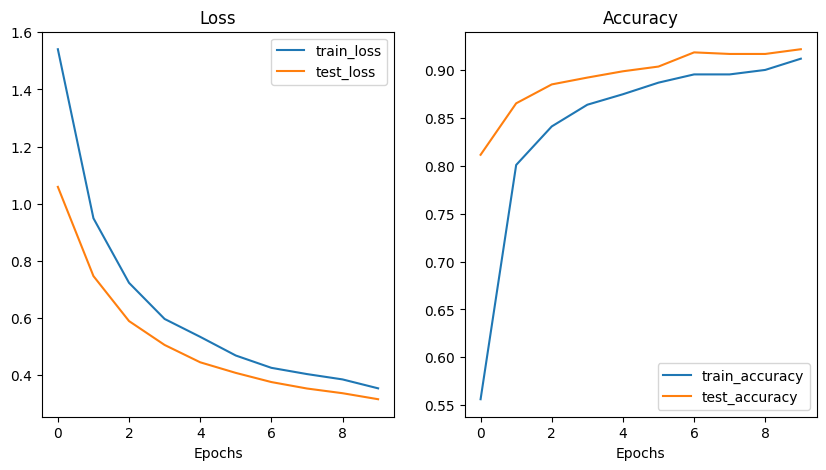

In [22]:
hlp.plot_loss_curves(trained_model_results)

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_10_2.jpg


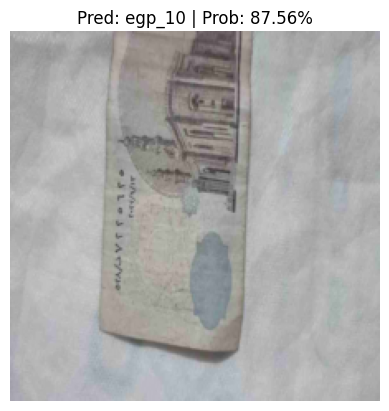

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_50_3.jpg


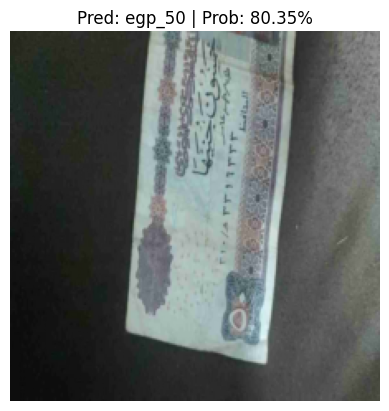

Predicting for image: drive/MyDrive/PyTorch/dataset_egp/validate/egp_10_0.jpg


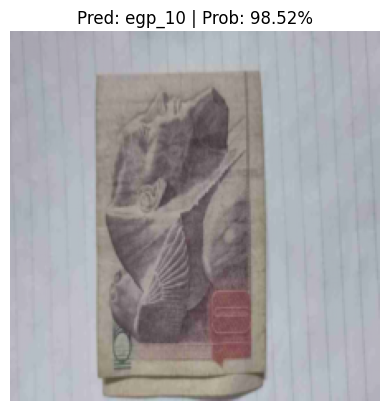

In [24]:
hlp.pred_and_plot_images(model=trained_model, image_dir=test_dir, class_names=class_names,
                         transform=custom_image_transform, device=device,num_images=3)